### Time-Series Analysis

In [1]:
reset -sf

In [3]:
from yahoo_finance import Share

In [4]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import IPython
from IPython.display import display, HTML
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.callbacks import Callback
from keras.models import load_model

Using TensorFlow backend.


In [5]:
pwd

'/Users/yun/gU/project/DSCI6005'

In [6]:
def get_yahoo_csv(symbols, years_before):
    '''
    INPUT: historical price for symbols in seleted period of time.
    OUTPUT: save as .csv file in each symbols.
    '''
    days_before = years_before * 365                          #trasfer years into days
    today = datetime.now().strftime('%Y-%m-%d')               #make today as str
    date = datetime.now() - timedelta(days=days_before)       #date is days before from today

    symbol = Share(symbols)                                 
    sym = pd.DataFrame(symbol.get_historical(date.strftime('%Y-%m-%d'), today))[::-1]
    sym.columns = map(str.lower, sym.columns)
    sym.index = sym['date']
    sym = sym.drop(['symbol', 'date'], axis=1)
    print("Inserted {} days {} data.".format(days_before, symbol.get_name()))
    sym.to_csv("{}.csv".format(symbol.get_name()))
    return sym

In [6]:
symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [11]:
'''
Data load with Yahoo Finance API, each symbol(stock) contain 10 years data from the date 5/5/2017.
With get_yahoo_csv, I can load data with any period and any symbols if yahoo finance API applied.
output will be .csv format which is the better for train deep learning model 
because yahoo API sometime disconnect by Yahoo API issues.
'''
apple = get_yahoo_csv('AAPL', 10)
google = get_yahoo_csv('GOOGL', 10)
ms = get_yahoo_csv('MSFT', 10)
amazon = get_yahoo_csv('AMZN', 10)
ibm = get_yahoo_csv('IBM', 10)

Inserted 3650 days Apple Inc. data.
Inserted 3650 days Alphabet Inc. data.
Inserted 3650 days Microsoft Corporation data.
Inserted 3650 days Amazon.com, Inc. data.


In [12]:
google.tail(2)

,adj_close,close,high,low,open,volume
date,,,,,,
2017-05-04,954.719971,954.719971,959.140015,947.369995,950.289978,1937600
2017-05-05,950.280029,950.280029,958.440002,948.099976,956.719971,1593900


In [13]:
pd.read_csv('Apple Inc..csv', index_col=None, header=0).head(2)

,date,adj_close,close,high,low,open,volume
0,2007-05-11,14.088305,108.739999,109.130001,106.780001,107.740003,163424100
1,2007-05-14,14.168632,109.360000,110.000001,108.250001,109.619999,162986600


In [7]:
def load_data(symbols, window, shuffle=True, norm_window=True):
    '''
    INPUT: load data from .csv file, and split by seq(window) time seris data in seleted window of time(days).
    OUTPUT: seperate train(90%) and test data(10%) for X and y.
    '''
    sym = pd.read_csv(symbols)                        #load .csv
    data = sym.ix[:, 'adj_close'].tolist()            #make list only for adj close price
   
    plt.figure(figsize=(15,8))
    plt.title(symbols, fontsize=18)                   #plot stock price by date
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price (Adj Close)', fontsize=15)
    plt.plot(data)
    plt.show()
    
    win_size = window + 1                             #set window(seq) size
    win_data = []                                     #make empty list for window data
    for i in range(len(data)-win_size):
        win_data.append(data[i:i+win_size])
    
    if norm_window:                                   #normalize window data
        win_data = norm_windows(win_data)
    else:
        win_data = np.asarray(win_data)

    r = round(0.9 * win_data.shape[0])                #ready to seperate train and test data
    tr = win_data[:int(r), :]                         #seperate for train, 90%
    te = win_data[int(r):, :]                         #seperate for test, 10%
    
    if shuffle:                                       #shuffling for train and label
        np.random.shuffle(tr)                         #shuffle when make model, but no shuffle for prediction
    
    plt.figure(figsize=(15,8))
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalized Price (Adj Close)', fontsize=15)
    plt.plot(tr)
    plt.show()
    
    X_train = tr[:, :-1]                              #seperate x and y for train data
    y_train = tr[:, -1]
    X_test = te[:, :-1]                               #seperate x and y for test data
    y_test = te[:, -1]     
    X_train = np.expand_dims(X_train, axis=2)         #expand dimension for train   
    X_test = np.expand_dims(X_test, axis=2)           #expand dimension for test
    return [X_train, y_train, X_test, y_test]

def norm_windows(win_data):
    '''
    INPUT: list of window data.
    OUTPUT: normalize window data(list), and put into matrix.
    '''
    norm_data = []                                    #make empty list for normalized window data
    for win in win_data:
        norm_window = [ele/win[0]-1 for ele in win]   #normalize [first element is zero for each window(seq) data]
        norm_data.append(norm_window)
    return np.asarray(norm_data)

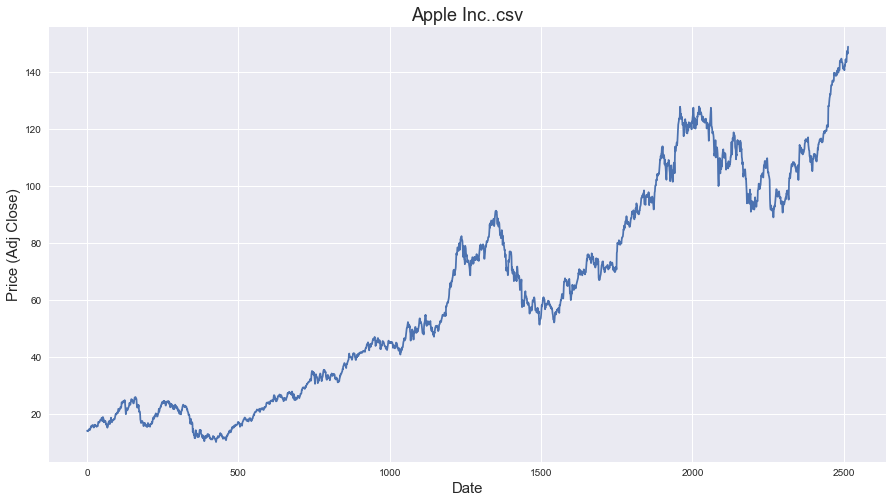

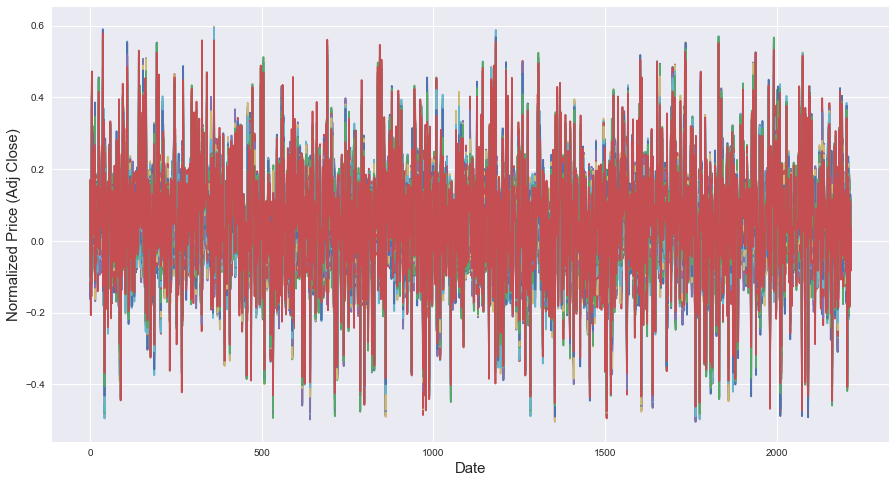

In [15]:
#split train and test data for apple and make plot for price moving and segmentation.
X_train, y_train, X_test, y_test = load_data('Apple Inc..csv', 50)

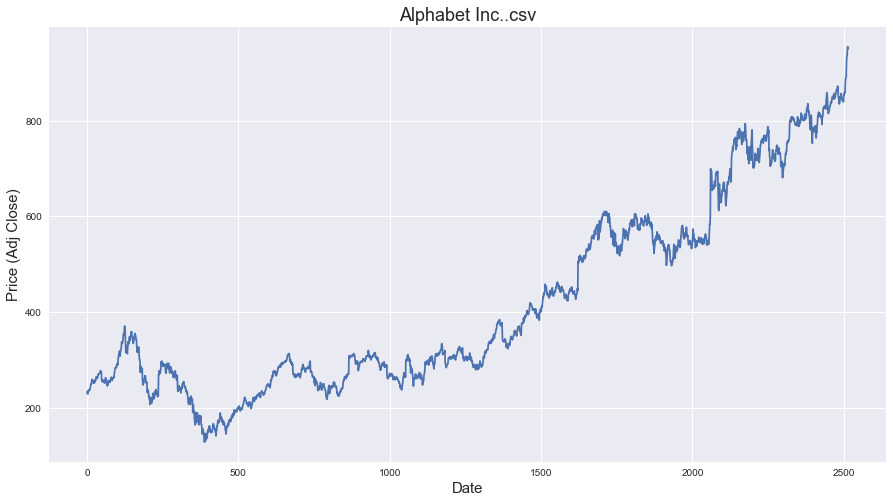

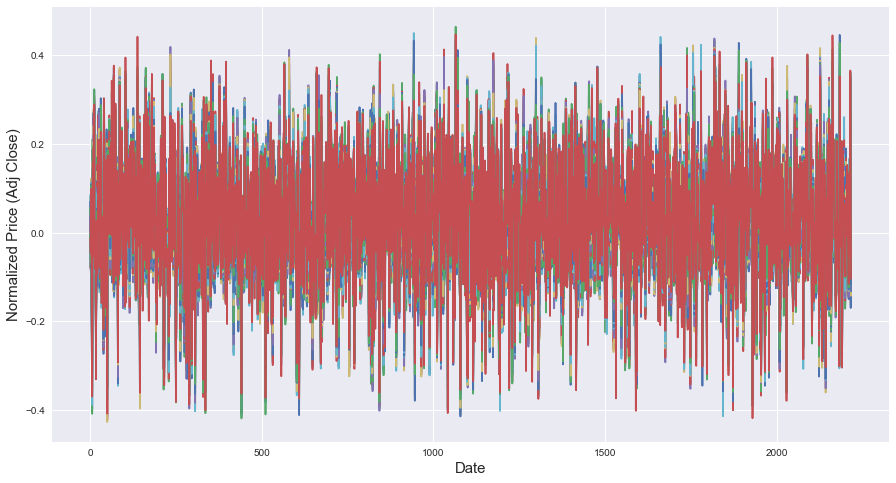

In [16]:
#split train and test data for google and make plot for price moving and segmentation.
X_train, y_train, X_test, y_test = load_data('Alphabet Inc..csv', 50)

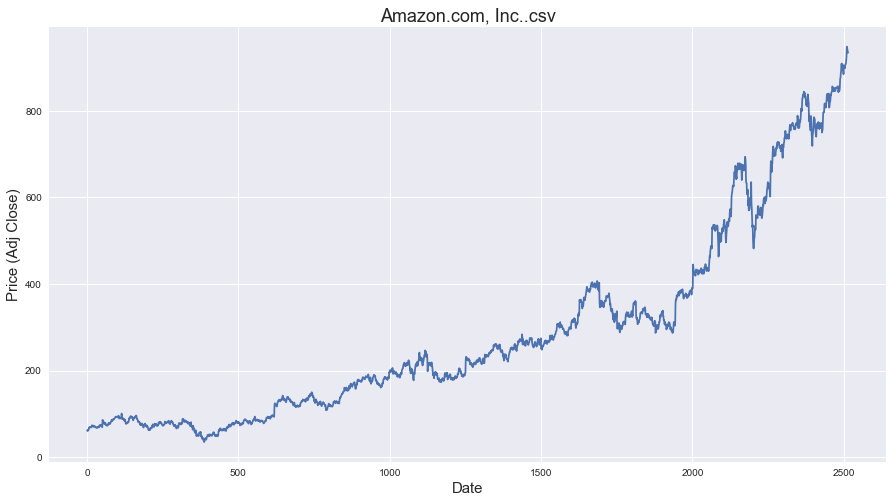

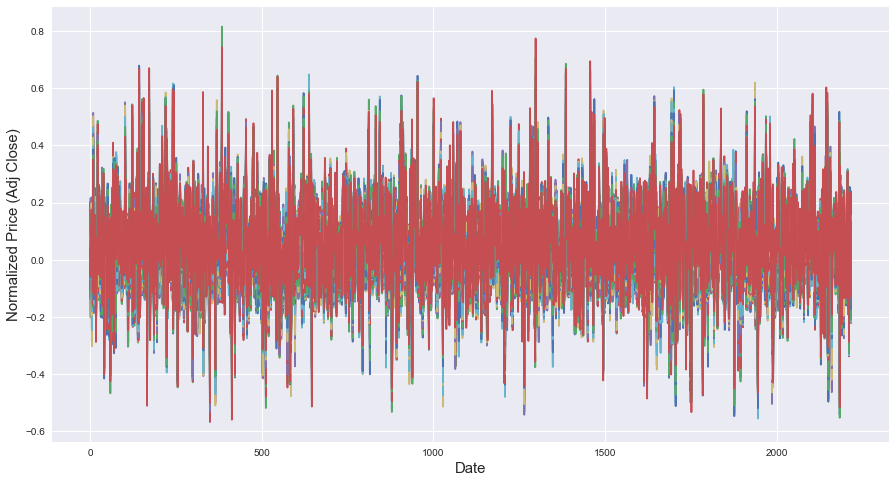

In [17]:
#split train and test data for amazon and make plot for price moving and segmentation.
X_train, y_train, X_test, y_test = load_data('Amazon.com, Inc..csv', 50)

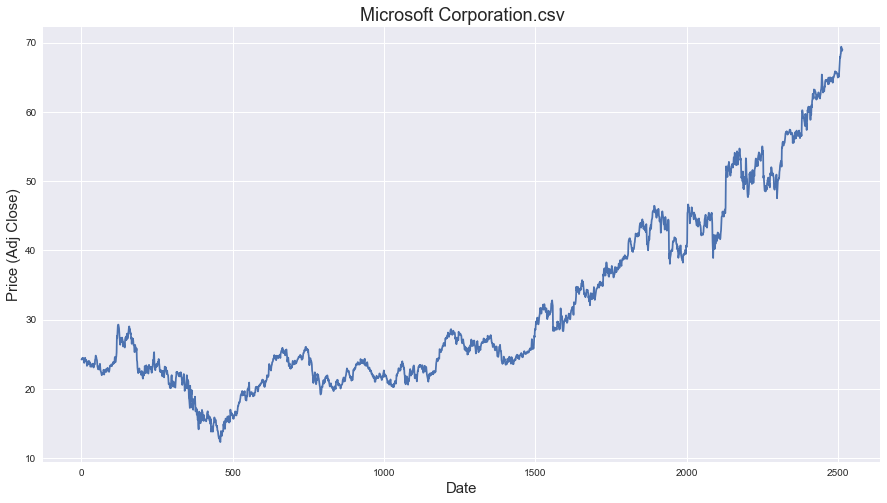

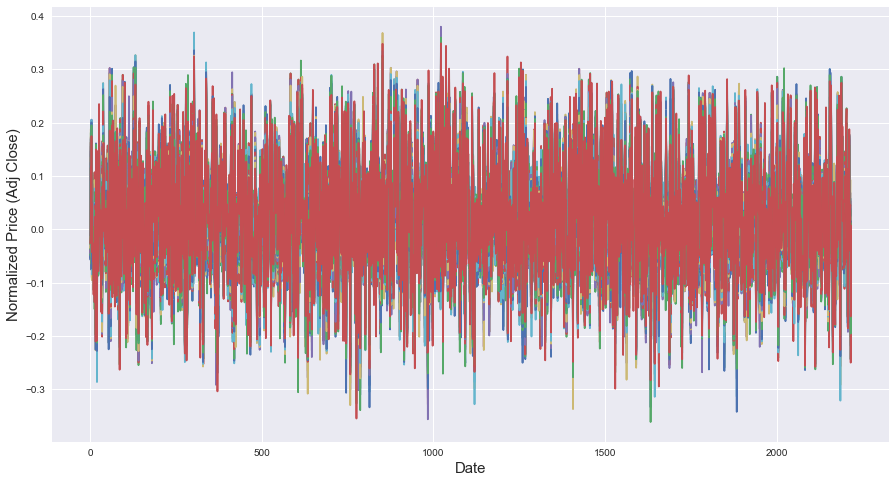

In [18]:
#split train and test data for microsoft and make plot for price moving and segmentation.
X_train, y_train, X_test, y_test = load_data('Microsoft Corporation.csv', 50)

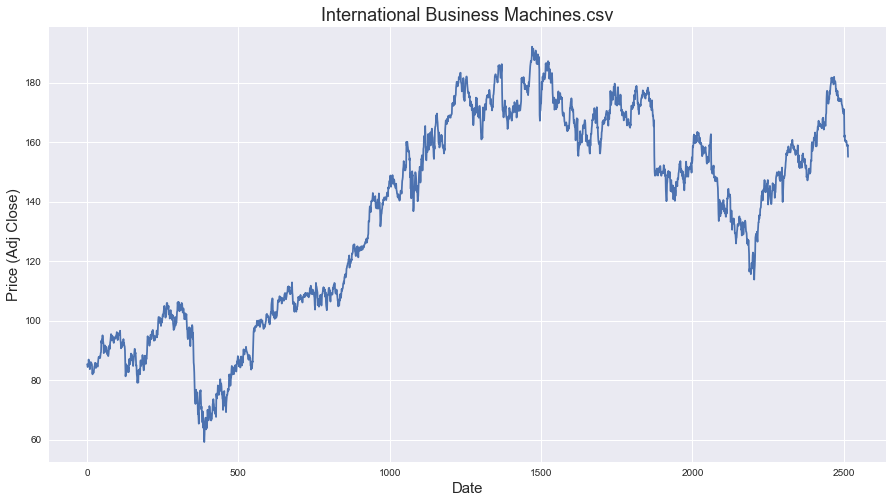

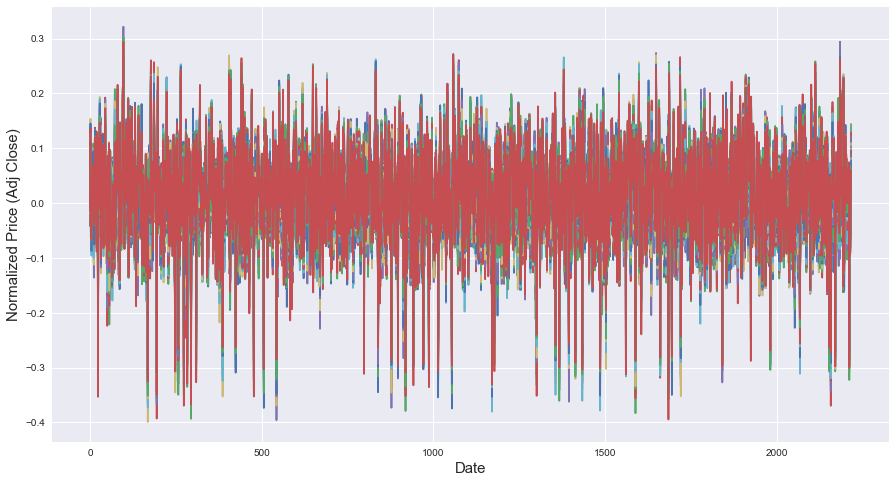

In [8]:
#split train and test data for apple and make plot for price moving and segmentation.
X_train, y_train, X_test, y_test = load_data('International Business Machines.csv', 50)

In [19]:
#check the shape in each train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2218, 50, 1), (246, 50, 1), (2218,), (246,))

In [20]:
def build_model(input_dim=1, output_dim=50, hidden_units=128, final_output_dim=1):
    """
    Input: Input and output dimension.
    Output: Build the LSTM model based on input, output dimension, and compailing with adam optimazer with mse.
    """
    print('Build model...')
    
    model = Sequential()                           #set the model       

    model.add(LSTM(input_dim=input_dim,            #add LSTM dense 
                   output_dim=output_dim, 
                   return_sequences=True))
    model.add(Dropout(0.2))                        #apply 20% dropout to avoid overfitteing

    model.add(LSTM(hidden_units, 
                   return_sequences=False))        #add LSTM dense
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=final_output_dim))  #apply 20% dropout to avoid overfitteing
    model.add(Activation('linear'))                #apply linear as an activation

    model.compile(loss='mse',                      #compile with adam and mse
                  optimizer='adam')

    model.summary()
    return model

In [21]:
#Build model
model = build_model()

Build model...


/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:169: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  warnings.warn('The `input_dim` and `input_length` arguments '
/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  '` call to the Keras 2 API: ' + signature)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 102,177.0
Trainable params: 102,177.0
Non-trainable params: 0.0
________________________________________________________________

/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  '` call to the Keras 2 API: ' + signature)


In [16]:
#Use tensorflow for tensorboard graph with keras
sess = tf.Session()
K.set_session(sess)

In [17]:
#Show tensorboard for keras model, LSTM
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph(sess.graph)

In [30]:
#Training model with list of companise stocks(symbols); 'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB', 'IBM'
print('Training...')

epochs = 10                       #set epochs, 10

model.fit(X_train, y_train,       #fit into model for train datas      
          batch_size=128,
          validation_data=(X_test, y_test),
          epochs=epochs)

Training...
Train on 2218 samples, validate on 246 samples
Epoch 1/10
2218/2218 [==============================] - 10s - loss: 2.8065e-04 - val_loss: 1.3560e-04
Epoch 2/10
2218/2218 [==============================] - 10s - loss: 2.7634e-04 - val_loss: 1.3047e-04
Epoch 3/10
2218/2218 [==============================] - 11s - loss: 2.8552e-04 - val_loss: 1.2740e-04
Epoch 4/10
2218/2218 [==============================] - 10s - loss: 2.9104e-04 - val_loss: 1.2649e-04
Epoch 5/10
2218/2218 [==============================] - 11s - loss: 2.7606e-04 - val_loss: 1.2765e-04
Epoch 6/10
2218/2218 [==============================] - 10s - loss: 2.7149e-04 - val_loss: 1.2411e-04
Epoch 7/10
2218/2218 [==============================] - 10s - loss: 2.7882e-04 - val_loss: 1.3077e-04
Epoch 8/10
2218/2218 [==============================] - 10s - loss: 2.8126e-04 - val_loss: 1.2311e-04
Epoch 9/10
2218/2218 [==============================] - 10s - loss: 2.7645e-04 - val_loss: 1.2184e-04
Epoch 10/10
2218/2218 [

In [18]:
#load TimeSeries_Ananlysis_YAHOO_API_Origin_Model model
model = load_model("TimeSeries_Ananlysis_YAHOO_API_Origin_Model.h5")

In [26]:
def pred_value(model, data):
    '''
    Input: model and data.
    Output: predict each timestep of data, it is predicted 1 step ahead each timestep.
    '''
    pred = model.predict(data)                 #predict values from data
    pred = np.reshape(pred, (pred.size,))      #reshape to reduce dimesion into the same shape as y values
    return pred

def pred_plot(pred_data, real_data):
    '''
    Input: predicted data & real data
    Output: compare b/t predicted data and real data
    '''
    plt.figure(figsize=(15,8))
    plt.plot(pred_data, label='Prediction', color='g', linewidth=3);
    plt.plot(real_data, label='Real Data', color='r', linewidth=3);
    plt.title('Validate Data b/w Prediction & Real', fontsize=18)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalized Price (Adj Close)', fontsize=15)
    plt.legend()
    plt.show()

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 23.1 µs


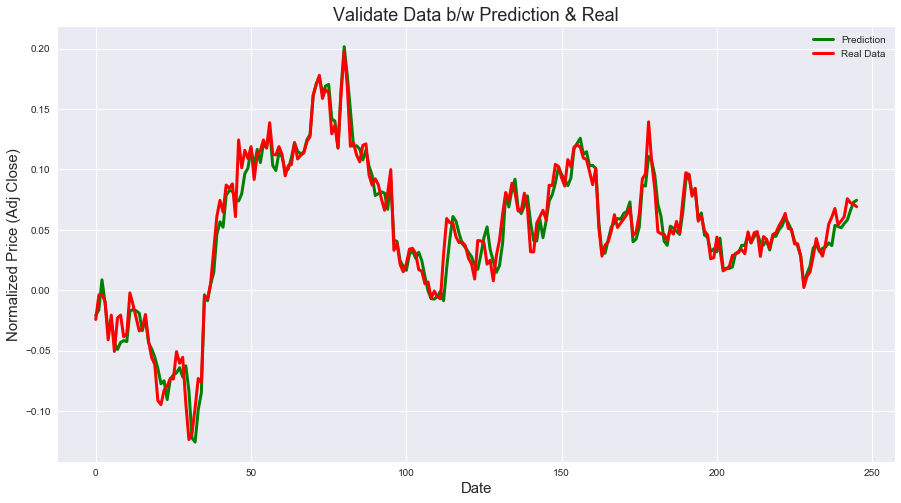

In [27]:
#MS
%time                               #check time for prediction
pred = pred_value(model, X_test)    #prediction with model for X_test data
pred_plot(pred, y_test)             #make plot prediction values and real values to compare

In [51]:
#save model
#model.save("TimeSeries_Ananlysis_YAHOO_API_Origin_Model.h5", overwrite=True)

In [28]:
def future_prediction(data, days):
    '''
    Input:  test data and days which you want to predict price in future.
             ex) future_prediction(X_test, 50) --> X_test(IBM) 50 days future price prediction from today.
    Output: normalized values of future price prediction for some days from today.
            Type - numpy.ndarray
    '''
    data = data[-1]                                             #the most recent data use for future prediction
    ft_y_vals = []                                              #the value of future price prediction
    for day in range(days):                            
        ft_win_data = data.reshape(1, 50, 1)                    #reshape data for model input
        ft_y_val = pred_value(model, ft_win_data).tolist()      #prediction values with pred_values function(list)
        ft_y_vals.append(ft_y_val)                              #make list of value of future prices
        data = data[-49:].reshape(data[-49:].shape[0],)         #segment 50days with adding predicted price for next prediction
        data = np.append(data, ft_y_val)                        
        data = np.asarray([((e+1)/(data[0]+1))-1 for e in data]) #re-normalize new segmented values(first values is zero)
    ft_y_vals = np.asarray(ft_y_vals)                            #make numpy array type from list
    ft_y_vals = ft_y_vals.reshape((ft_y_vals.size,))             #change shape (50,1) to (50,)  
    return ft_y_vals

In [29]:
'''
Predict next 50 days price.
The reason for 50 days prediction is the segmented input size is 50 days, 
so over 50 days will make price prediction from predicted price, which make less accurate for sensitive stock market.
'''
future_price = future_prediction(X_test, 50)

In [30]:
#append numpy array type matrixs pred and future price
new_y_pred = np.append(pred, future_price)

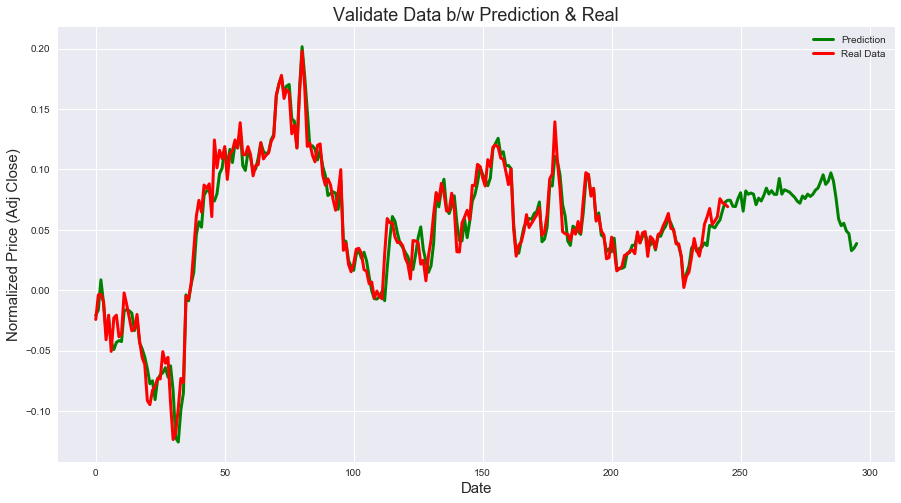

In [31]:
#make plot for ** stock price next 50 days from 5/5/2017.
pred_plot(new_y_pred, y_test)

In [6]:
#run python file and show results

In [2]:
import getData_yahoo
import TimeSeries_Analysis_YAHOO_API_LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob

Using TensorFlow backend.


Inserted 3650 days Apple Inc. data.
Inserted 3650 days Alphabet Inc. data.
Inserted 3650 days Microsoft Corporation data.
Inserted 3650 days Amazon.com, Inc. data.
Inserted 3650 days International Business Machines data.
Build model...


/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:169: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  warnings.warn('The `input_dim` and `input_length` arguments '
/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  '` call to the Keras 2 API: ' + signature)
/Users/yun/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  '` call to the Keras 2 API: ' + signature)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 102,177.0
Trainable params: 102,177.0
Non-trainable params: 0.0
________________________________________________________________

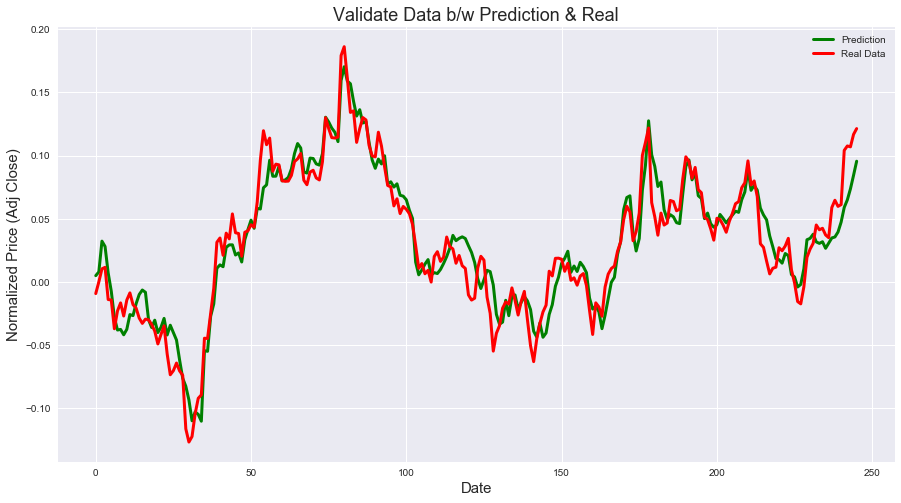

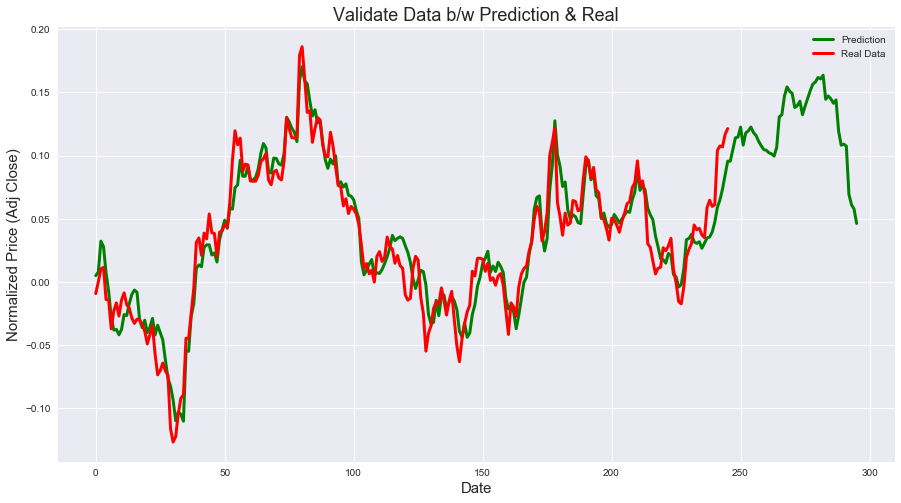

Loading data...
Data Loaded.
Training...
Train on 2218 samples, validate on 246 samples
Epoch 1/10
2218/2218 [==============================] - 10s - loss: 0.0017 - val_loss: 3.9350e-04
Epoch 2/10
2218/2218 [==============================] - 9s - loss: 0.0019 - val_loss: 3.3112e-04
Epoch 3/10
2218/2218 [==============================] - 12s - loss: 0.0018 - val_loss: 3.4854e-04
Epoch 4/10
2218/2218 [==============================] - 13s - loss: 0.0016 - val_loss: 3.0079e-04
Epoch 5/10
2218/2218 [==============================] - 11s - loss: 0.0015 - val_loss: 3.0675e-04
Epoch 6/10
2218/2218 [==============================] - 13s - loss: 0.0015 - val_loss: 2.8399e-04
Epoch 7/10
2218/2218 [==============================] - 11s - loss: 0.0015 - val_loss: 2.8876e-04
Epoch 8/10
2218/2218 [==============================] - 11s - loss: 0.0015 - val_loss: 2.5881e-04
Epoch 9/10
2218/2218 [==============================] - 11s - loss: 0.0013 - val_loss: 2.7623e-04
Epoch 10/10
2218/2218 [========

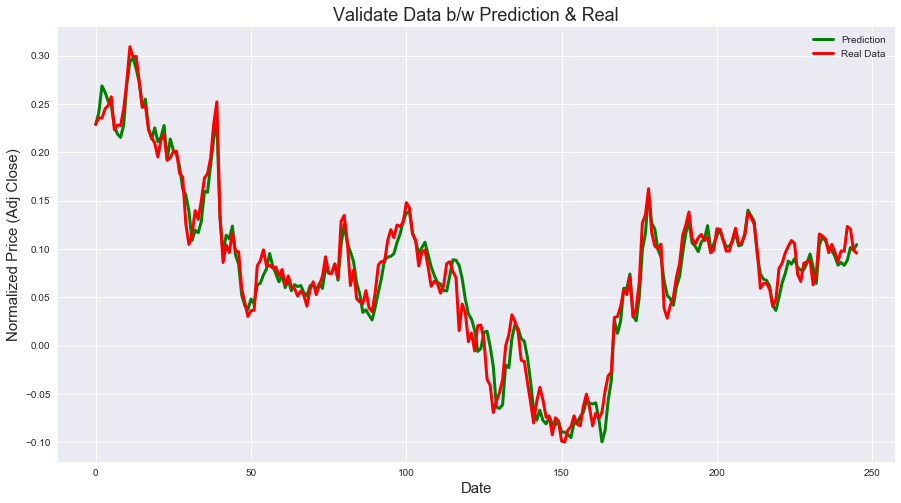

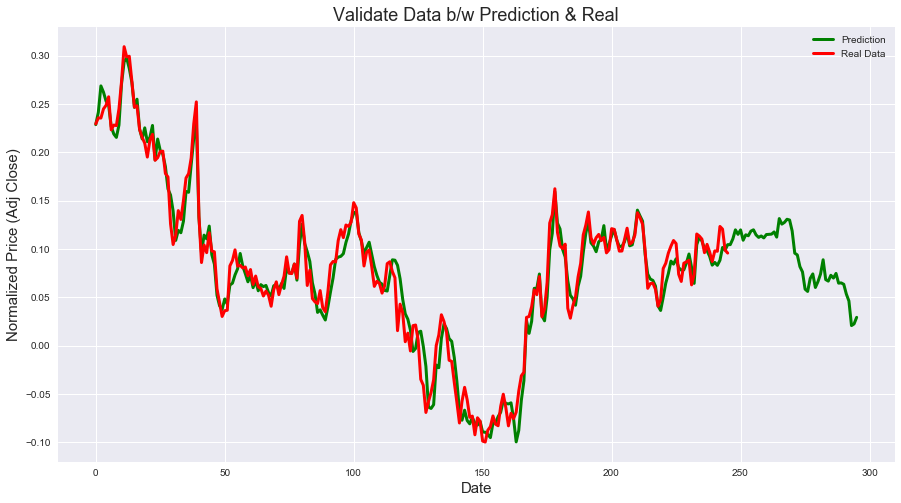

Loading data...
Data Loaded.
Training...
Train on 2218 samples, validate on 246 samples
Epoch 1/10
2218/2218 [==============================] - 11s - loss: 9.1852e-04 - val_loss: 2.3440e-04
Epoch 2/10
2218/2218 [==============================] - 10s - loss: 8.3951e-04 - val_loss: 2.6287e-04
Epoch 3/10
2218/2218 [==============================] - 10s - loss: 8.8266e-04 - val_loss: 2.4181e-04
Epoch 4/10
2218/2218 [==============================] - 10s - loss: 8.7764e-04 - val_loss: 2.2387e-04
Epoch 5/10
2218/2218 [==============================] - 10s - loss: 8.3794e-04 - val_loss: 2.2431e-04
Epoch 6/10
2218/2218 [==============================] - 10s - loss: 8.0721e-04 - val_loss: 2.3252e-04
Epoch 7/10
2218/2218 [==============================] - 10s - loss: 8.3536e-04 - val_loss: 2.1627e-04
Epoch 8/10
2218/2218 [==============================] - 10s - loss: 8.2801e-04 - val_loss: 2.2587e-04
Epoch 9/10
2218/2218 [==============================] - 10s - loss: 8.2301e-04 - val_loss: 2.084

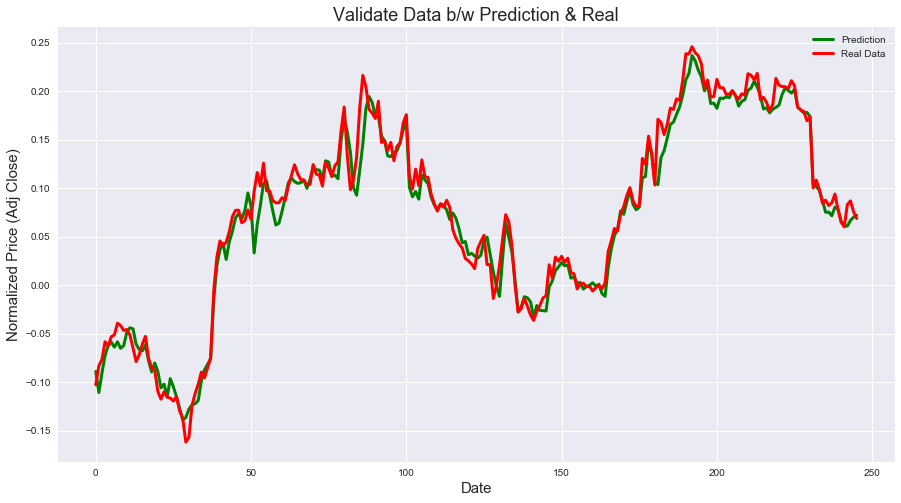

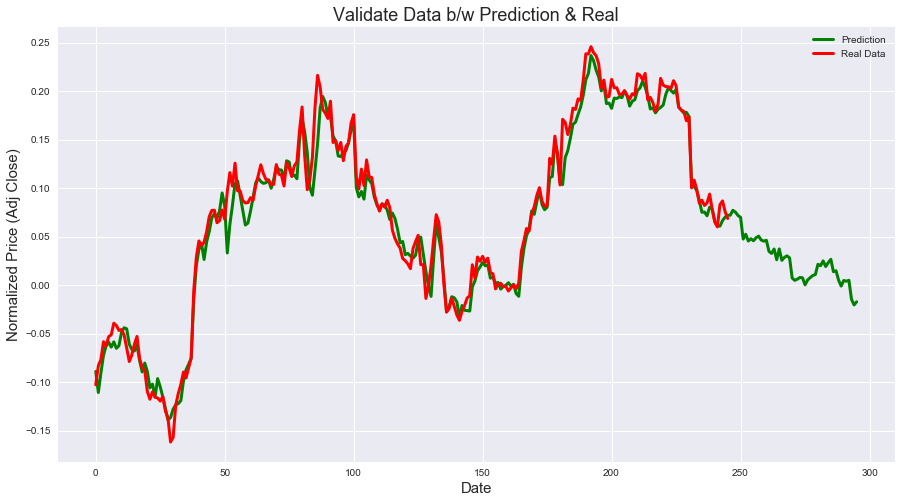

Loading data...
Data Loaded.
Training...
Train on 2218 samples, validate on 246 samples
Epoch 1/10
2218/2218 [==============================] - 11s - loss: 3.1777e-04 - val_loss: 1.4966e-04
Epoch 2/10
2218/2218 [==============================] - 10s - loss: 3.1277e-04 - val_loss: 1.4426e-04
Epoch 3/10
2218/2218 [==============================] - 10s - loss: 3.1496e-04 - val_loss: 1.4197e-04
Epoch 4/10
2218/2218 [==============================] - 10s - loss: 3.0574e-04 - val_loss: 1.3747e-04
Epoch 5/10
2218/2218 [==============================] - 10s - loss: 3.2972e-04 - val_loss: 1.3791e-04
Epoch 6/10
2218/2218 [==============================] - 10s - loss: 2.9245e-04 - val_loss: 1.4049e-04
Epoch 7/10
2218/2218 [==============================] - 10s - loss: 3.0018e-04 - val_loss: 1.4224e-04
Epoch 8/10
2218/2218 [==============================] - 10s - loss: 3.0854e-04 - val_loss: 1.3338e-04
Epoch 9/10
2218/2218 [==============================] - 10s - loss: 2.9350e-04 - val_loss: 1.344

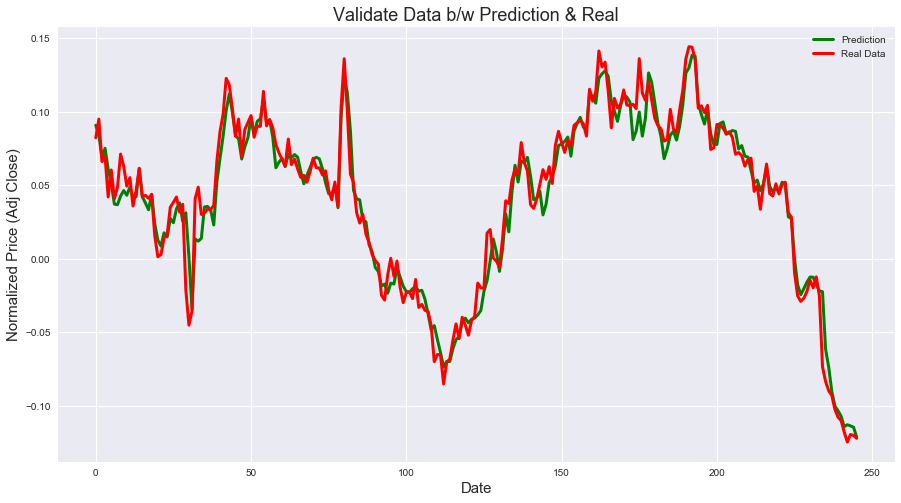

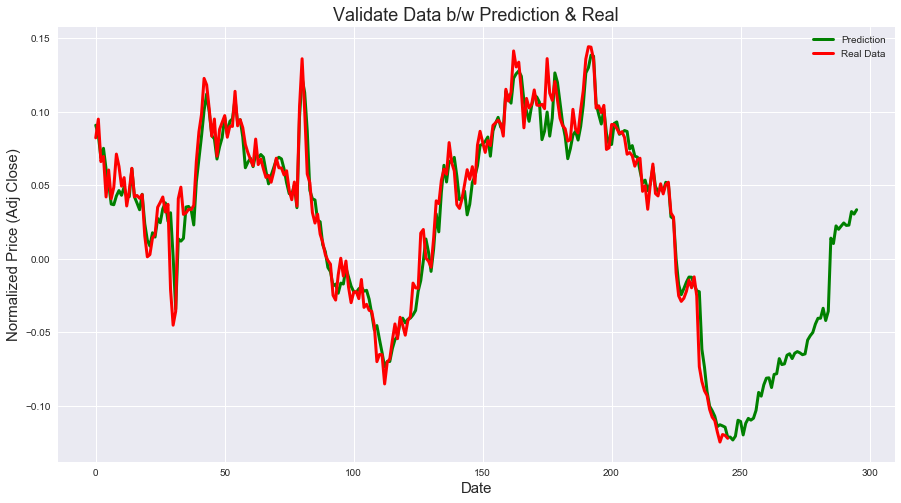

Loading data...
Data Loaded.
Training...
Train on 2218 samples, validate on 246 samples
Epoch 1/10
2218/2218 [==============================] - 10s - loss: 4.5689e-04 - val_loss: 1.3231e-04
Epoch 2/10
2218/2218 [==============================] - 10s - loss: 4.5486e-04 - val_loss: 1.5330e-04
Epoch 3/10
2218/2218 [==============================] - 11s - loss: 4.7259e-04 - val_loss: 1.2851e-04
Epoch 4/10
2218/2218 [==============================] - 10s - loss: 4.5890e-04 - val_loss: 1.2920e-04
Epoch 5/10
2218/2218 [==============================] - 10s - loss: 4.7239e-04 - val_loss: 1.3057e-04
Epoch 6/10
2218/2218 [==============================] - 10s - loss: 4.4992e-04 - val_loss: 1.2668e-04
Epoch 7/10
2218/2218 [==============================] - 10s - loss: 4.7166e-04 - val_loss: 1.2963e-04
Epoch 8/10
2218/2218 [==============================] - 10s - loss: 4.5451e-04 - val_loss: 1.2730e-04
Epoch 9/10
2218/2218 [==============================] - 10s - loss: 4.5735e-04 - val_loss: 1.269

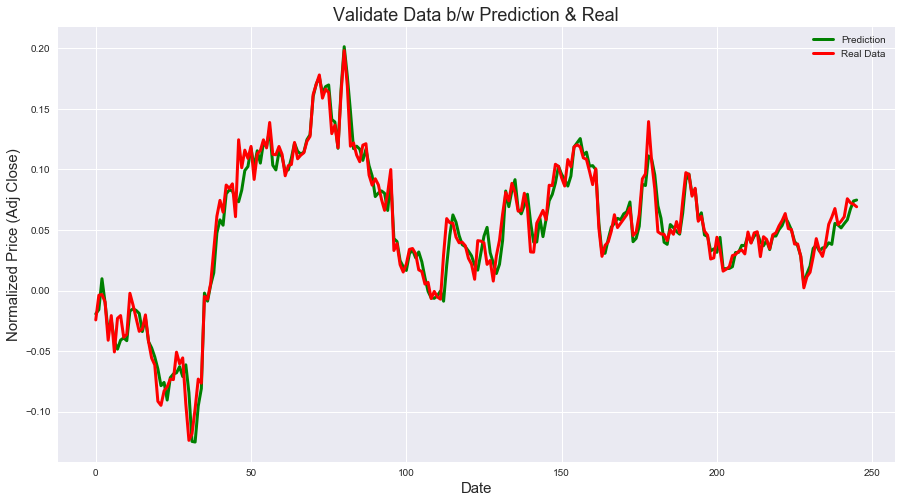

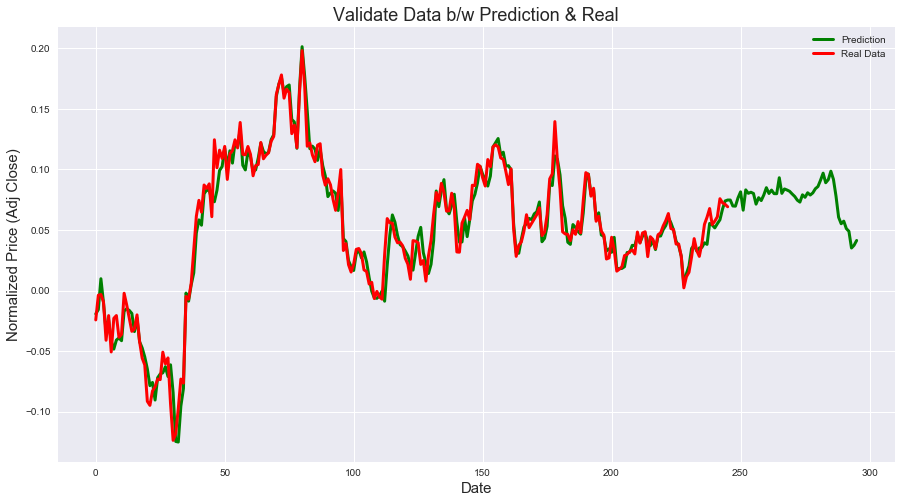

In [5]:
def pred_plot(pred_data, real_data):
    '''
    Input: predicted data & real data
    Output: compare b/t predicted data and real data
    '''
    plt.figure(figsize=(15,8))
    plt.plot(pred_data, label='Prediction', color='g', linewidth=3);
    plt.plot(real_data, label='Real Data', color='r', linewidth=3);
    plt.title('Validate Data b/w Prediction & Real', fontsize=18)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalized Price (Adj Close)', fontsize=15)
    plt.legend()
    plt.show()

def future_prediction(data, days):
    '''
    Input:  test data and days which you want to predict price in future.
             ex) future_prediction(X_test, 50) --> X_test(IBM) 50 days future price prediction from today.
    Output: normalized values of future price prediction for some days from today.
            Type - numpy.ndarray
    '''
    data = data[-1]                                                                                #the most recent data use for future prediction
    ft_y_vals = []                                                                                 #the value of future price prediction
    for day in range(days):                            
        ft_win_data = data.reshape(1, 50, 1)                                                       #reshape data for model input
        ft_y_val = TimeSeries_Analysis_YAHOO_API_LSTM.pred_value(model, ft_win_data).tolist()      #prediction values with pred_values function(list)
        ft_y_vals.append(ft_y_val)                                                                 #make list of value of future prices
        data = data[-49:].reshape(data[-49:].shape[0],)                                            #segment 50days with adding predicted price for next prediction
        data = np.append(data, ft_y_val)                        
        data = np.asarray([((e+1)/(data[0]+1))-1 for e in data])                                   #re-normalize new segmented values(first values is zero)
    ft_y_vals = np.asarray(ft_y_vals)                                                              #make numpy array type from list
    ft_y_vals = ft_y_vals.reshape((ft_y_vals.size,))                                               #change shape (50,1) to (50,)  
    return ft_y_vals    

#Main Run
if __name__=='__main__':
    symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'IBM']
    for sym in symbols:
        getData_yahoo.get_yahoo_csv(sym, 10)

    epochs  = 10             #set epochs, 10
    window = 50              #set window(segment or sequence), 50 days
    
    #Build model
    model = TimeSeries_Analysis_YAHOO_API_LSTM.build_model()
    
    #set the path where glob the .csv files
    path = '*.csv'
    files = glob.glob(path)
    
    #train model number of times which is the same number with symbols(for Demo 3 times)
    for f in files:  
        #split train and test data for apple and make plot for price moving and segmentation.
        X_train, y_train, X_test, y_test = TimeSeries_Analysis_YAHOO_API_LSTM.load_data(f, window)

        #Training model with list of companise stocks(symbols); 'AAPL', 'GOOGL', 'MSFT'
        print('Training...')

        #fit into model for train datas
        model.fit(X_train, y_train,                          
                  batch_size=128,
                  validation_data=(X_test, y_test),
                  epochs=epochs)

        #save model
        model.save("TimeSeries_Ananlysis_YAHOO_API_{}.h5".format(f), overwrite=True)
        print("Save Model for {}".format(f))
        
        #check time for prediction
        %%time

        #prediction with model for X_test data
        pred = TimeSeries_Analysis_YAHOO_API_LSTM.pred_value(model, X_test)

        #make plot prediction values and real values to compare
        pred_plot(pred, y_test)
        future_price = future_prediction(X_test, window)

        #append numpy array type matrixs pred and future price
        new_y_pred = np.append(pred, future_price)
    
        #make plot for IBM stock price next 50 days from 5/5/2017.
        pred_plot(new_y_pred, y_test)